## IMPORTS

In [28]:
import numpy as np
import matplotlib as mpl
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import gymnasium as gym
from matplotlib import colors
from IPython.display import clear_output
from time import sleep

## ENVIRONMENT AND VARIABLES

In [29]:
env = gym.make("Taxi-v3")
state, info = env.reset()


def stateinfo2state(state_info):
    taxi_row = state_info[0]
    taxi_column = state_info[1]
    passenger_location = state_info[2]
    destination = state_info[3]
    return ((taxi_row*5 + taxi_column)*5 + passenger_location)*4 + destination

def state2stateinfo(state):
    destination = state % 4
    passenger_location = int(state/4)%5
    taxi_column = int(int(state/4)/5)%5
    taxi_row = int(int(int(state/4)/5)/5)

    return [taxi_row, taxi_column, passenger_location, destination]

primitive_actions = ['SOUTH', 'NORTH', 'EAST', 'WEST', 'PICKUP', 'DROP-OFF']
movement_actions = ['SOUTH', 'NORTH', 'EAST', 'WEST']
passenger_locations = ['R', 'G', 'Y', 'B', 'T']
destinations = ['R', 'G', 'Y', 'B']


#The below actions are available for our SMDP Policy
actions = ['PICKUP', 'DROP-OFF', 'REACH RED', 'REACH GREEN', 'REACH YELLOW', 'REACH BLUE']

num_states = 500
num_actions = 2
num_options = 4
Q = np.zeros((num_states, num_actions+num_options))
num_taxiLoc = 25
num_movement_actions = 4
Qred = np.zeros((num_taxiLoc, num_movement_actions))
Qgreen = np.zeros((num_taxiLoc, num_movement_actions))
Qyellow = np.zeros((num_taxiLoc, num_movement_actions))
Qblue = np.zeros((num_taxiLoc, num_movement_actions))

[2, 3, 2, 0]


<Figure size 1280x960 with 0 Axes>

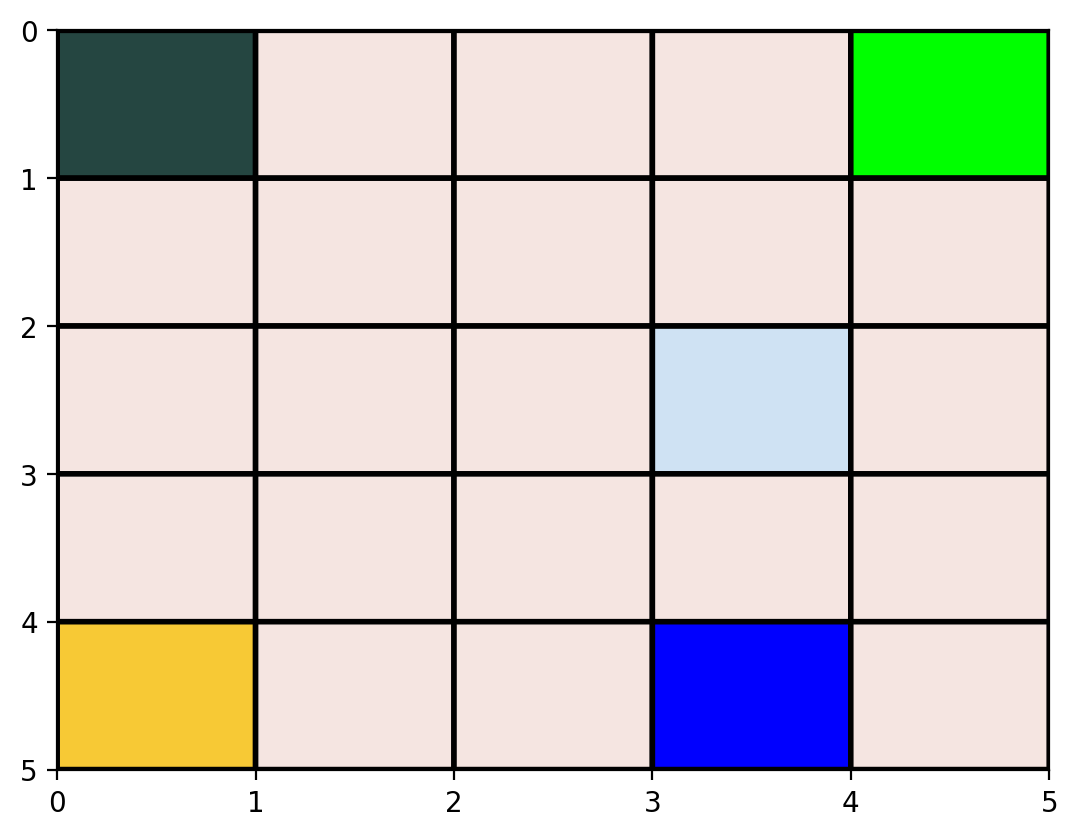

In [30]:
def render(state):
        grid = np.zeros((5,5))
        taxi_row, taxi_column, passenger_location, destination = state2stateinfo(state)

        grid[0,0] = 1
        grid[0,4] = 2
        grid[4,0] = 3
        grid[4,3] = 4

        grid[taxi_row, taxi_column] = 5

        locations = [[0,0], [0,4], [4,0], [4,3]]
        
        if passenger_location<4:
            passengerX, passengerY = locations[passenger_location]
        else:
            passengerX, passengerY = taxi_row, taxi_column
        destinationX, destinationY = locations[destination]

        grid[passengerX, passengerY] = 6
        grid[destinationX, destinationY] = 7

        cmap = colors.ListedColormap(['#F5E5E1','#FF0000','#00FF00','#FFFF00','#0000FF','#CFE2F3','#F7C935','#254641'])
        # red, green, yellow, blue, taxi, passenger, destination 

        plt.clf()
        fig, ax = plt.subplots()
        ax.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=2)
        ax.set_ylim(ax.get_ylim()[::-1])
#         ax.text(passengerX+0.5, passengerY+0.5, 'P', color='black', ha='center', va='center', fontsize=15)
#         ax.text(destinationX+0.5, destinationY+0.5, 'D', color='black', ha='center', va='center', fontsize=15)
        
state, _ = env.reset()
print(state2stateinfo(state))
render(state)

In [31]:
def reachRed(state, epsilon=0.01, num_actions=4):
    optdone = False
    if np.random.random() < epsilon:
        optact = np.random.choice(np.arange(num_actions))
    else:
        optact = np.argmax(Qred[state])

    taxi_column = state % 5
    taxi_row = int(state/5)
    if [taxi_row, taxi_column] == [0, 0]:
        optdone = True

    return [optact, optdone]


def reachGreen(state, epsilon=0.01, num_actions=4):
    optdone = False
    if np.random.random() < epsilon:
        optact = np.random.choice(np.arange(num_actions))
    else:
        optact = np.argmax(Qgreen[state])

    taxi_column = state % 5
    taxi_row = int(state/5)
    if [taxi_row, taxi_column] == [0, 4]:
        optdone = True

    return [optact, optdone]


def reachYellow(state, epsilon=0.01, num_actions=4):
    optdone = False
    if np.random.random() < epsilon:
        optact = np.random.choice(np.arange(num_actions))
    else:
        optact = np.argmax(Qyellow[state])

    taxi_column = state % 5
    taxi_row = int(state/5)
    if [taxi_row, taxi_column] == [4, 0]:
        optdone = True

    return [optact, optdone]


def reachBlue(state, epsilon=0.01, num_actions=4):
    optdone = False
    if np.random.random() < epsilon:
        optact = np.random.choice(np.arange(num_actions))
    else:
        optact = np.argmax(Qblue[state])

    taxi_column = state % 5
    taxi_row = int(state/5)
    if [taxi_row, taxi_column] == [4, 3]:
        optdone = True

    return [optact, optdone]

option_handles = [reachRed,reachGreen,reachYellow,reachBlue]

## LEARNING ALGORITHMS

### SMDP Q- Learning

In [32]:
def SMDP_Qlearning(option_Qs, option_handles, epsilon=0.01, alpha=0.4, gamma=0.9, total_episodes=100):
    episodic_returns = []
    for episodes in tqdm(range(total_episodes)):
        state, _ = env.reset()
        done1 = done2 = done = False
        steps = 0
        return_per_episode = 0
        while not done:
            if np.random.random() < epsilon:
                action = np.random.choice(np.arange(num_actions+num_options))
            else:
                action = np.argmax(Q[state])

            if action < num_actions:
                next_state, reward, done1, done2, _ = env.step(primitive_actions.index(actions[action]))
                done = done1 or done2
                Q[state, action] = Q[state, action] + alpha * \
                    (reward + gamma*np.max(Q[next_state]) - Q[state, action])
                state = next_state
                return_per_episode += (gamma**steps) * reward
                steps += 1 

            else:
                start_state = state
                returns = 0
                count = 0
                optdone = False
                flag = 0
                while not done:
                    stateinfo = state2stateinfo(state)
                    taxiLoc = stateinfo[0]*5+stateinfo[1]

                    optact, optdone = option_handles[action-num_actions](taxiLoc)

                    if optdone and count != 0:
                        break
                    elif optdone and count == 0:
                        returns = -1
                        count+=1
                        break
                    next_state, reward, done1, done2, _ = env.step(optact)
                    done = done1 or done2
                    returns = returns + (gamma**count)*reward
                    count += 1

                    next_stateinfo = state2stateinfo(next_state)
                    next_taxiLoc = next_stateinfo[0]*5+next_stateinfo[1]
                    
                    if not optdone:
                        option_Qs[action-num_actions][taxiLoc, optact] = \
                        option_Qs[action-num_actions][taxiLoc, optact] + alpha * \
                        (reward + gamma * np.max(option_Qs[action-num_actions][next_taxiLoc]) \
                         - option_Qs[action-num_actions][taxiLoc, optact])

                    state = next_state
                    
                return_per_episode += (gamma**steps) * returns
                steps += count
                    
                Q[start_state, action] = Q[start_state, action] + alpha * \
                    (returns + (gamma**count) *
                        np.max(Q[state]) - Q[start_state, action])
                
        episodic_returns.append(return_per_episode)
                
    return option_Qs, Q, episodic_returns

### Intra Option Q - Learning

In [60]:
def IO_Qlearning(option_Qs, option_handles, epsilon=0.01, alpha=0.4, gamma=0.9, total_episodes=1000):
    episodic_returns = []
    for episodes in tqdm(range(total_episodes)):
        state, _ = env.reset()
        done1 = done2 = done = False
        optflag = -1
        return_per_episode = 0
        steps = 0
        while not done:
            stateinfo = state2stateinfo(state)
            taxiLoc = stateinfo[0]*5+stateinfo[1]
            if optflag == -1:
                if np.random.random() < epsilon:
                    action = np.random.choice(np.arange(num_actions+num_options))
                else:
                    action = np.argmax(Q[state])
                if action >= num_actions:
                    optflag = action - num_actions
            if optflag >=0:
                optact, optdone = option_handles[optflag](taxiLoc)
                next_state, reward, done1, done2, _ = env.step(optact)
                done = done1 or done2
                
                next_stateinfo = state2stateinfo(next_state)
                next_taxiLoc = next_stateinfo[0]*5+next_stateinfo[1]
                # Update Option Policy
                if not optdone:
                    option_Qs[optflag][taxiLoc, optact] = option_Qs[optflag][taxiLoc, optact] + alpha * \
                        (reward + gamma*np.max(option_Qs[optflag][next_taxiLoc]) - option_Qs[optflag][taxiLoc, optact])
                # Update Q of option
                _,terminate = option_handles[optflag](next_taxiLoc)
                if terminate:
                    optflag = -1
                    Q[state, action] = Q[state, action] + alpha * \
                        (reward + gamma*np.max(Q[next_state]) - Q[state, action])
                else:
                    Q[state, action] = Q[state, action] + alpha * \
                        (reward + gamma*Q[next_state,action] - Q[state, action])
                # Update Q of primitive
#                 Q[state, optact] = Q[state, optact] + alpha * \
#                     (reward + gamma*np.max(Q[next_state]) - Q[state, optact])
                update_act = optact
            else:
                
                next_state, reward, done1, done2, _ = env.step(primitive_actions.index(actions[action]))
                done = done1 or done2
                next_stateinfo = state2stateinfo(next_state)
                next_taxiLoc = next_stateinfo[0]*5+next_stateinfo[1]
                Q[state, action] = Q[state, action] + alpha * \
                        (reward + gamma*np.max(Q[next_state]) - Q[state, action])
                update_act = primitive_actions.index(actions[action])
                
            return_per_episode += (gamma**steps) * reward
            
            #Update Matching Options
            for i in range(num_options):
                if (i != action - num_actions) and (np.argmax(option_Qs[i][taxiLoc]) == update_act):
                    _,terminate = option_handles[i](next_taxiLoc)
                    if terminate:
                        Q[state, i + num_actions] = Q[state, i + num_actions] + alpha * \
                            (reward + gamma*np.max(Q[next_state]) - Q[state, i + num_actions])
                    else:
                        Q[state, i + num_actions] = Q[state, i + num_actions] + alpha * \
                            (reward + gamma*Q[next_state, i + num_actions] - Q[state, i + num_actions])
            state = next_state
            steps += 1 
            
        episodic_returns.append(return_per_episode)
            
    return option_Qs, Q, episodic_returns

## PLOTTING TOOLS

### Plot outer Q Map 

In [34]:
def plot_Qmap_outer(Q):
    mpl.rcParams['figure.dpi'] = 200
    Qplot = np.zeros((5, 5), dtype=int)
    passenger_location = np.random.randint(0, 5)
    destination = np.random.randint(0, 4)
    while destination == passenger_location:
        destination = np.random.randint(0, 4)

    plt.title(
        f"Passenger = {passenger_locations[passenger_location]}, Destination = {destinations[destination]}, ")

    for i in range(5):
        for j in range(5):
            stateinfo = [i, j, passenger_location, destination]
            Qplot[i, j] = np.argmax(Q[stateinfo2state(stateinfo)])

    colors = []
    for i in actions:
        if i == "REACH RED":
            colors.append((1, 0, 0))
        elif i == "REACH GREEN":
            colors.append((0, 189/255, 0))
        elif i == "REACH BLUE":
            colors.append((0, 0, 1))
        elif i == "REACH YELLOW":
            colors.append((167/255, 201/255, 0))
        elif i == "PICKUP":
            colors.append((235/255,129/255,1))
        elif i == "DROP-OFF":
            colors.append((103/255,240/255,135/255))
        elif i == "SOUTH":
            colors.append((113/255,201/255,168/255))
        elif i == "NORTH":
            colors.append((193/255,172/255,86/255))
        elif i == "EAST":
            colors.append((193/255,172/255,86/255))
        elif i == "WEST":
            colors.append((193/255,86/255,86/255))
    if len(colors) == len(actions):
        cmap_custom = ListedColormap(colors)
        plt.imshow(Qplot, cmap=cmap_custom, vmin=0, vmax = len(actions)-1)
    else:
        plt.imshow(Qplot, cmap='viridis', vmin=0, vmax = len(actions)-1)


    for i in range(5):
        for j in range(5):
            text = plt.text(j, i, actions[Qplot[i, j]],
                            ha="center", va="center", color="w", size="xx-small")
    plt.show()


### Plot Option Q Maps


In [35]:
def plot_option_Q_maps(Qred,Qgreen,Qyellow,Qblue):
    mpl.rcParams['figure.dpi'] = 200
    fig, ax = plt.subplots(2,2)
    Qpred = np.zeros((5,5), dtype=int)
    Qpgreen = np.zeros((5,5), dtype=int)
    Qpyellow = np.zeros((5,5), dtype=int)
    Qpblue = np.zeros((5,5), dtype=int)
    for i in range(5):
        for j in range(5):
            Qpred[i,j] = np.argmax(Qred[5*i + j])
            Qpgreen[i,j] = np.argmax(Qgreen[5*i + j])
            Qpyellow[i,j] = np.argmax(Qyellow[5*i + j])
            Qpblue[i,j] = np.argmax(Qblue[5*i + j])
    fig.suptitle('Option Q Maps', fontsize=20)

    ax[0,0].title.set_text("Red")
    ax[0,1].title.set_text("Green")
    ax[1,0].title.set_text("Yellow")
    ax[1,1].title.set_text("Blue")
    ax[0,0].imshow(Qpred, cmap='viridis', interpolation='nearest')
    ax[0,1].imshow(Qpgreen, cmap='viridis', interpolation='nearest')
    ax[1,0].imshow(Qpyellow, cmap='viridis', interpolation='nearest')
    ax[1,1].imshow(Qpblue, cmap='viridis', interpolation='nearest')
    for i in range(5):
        for j in range(5):
            text1 = ax[0,0].text(j, i, primitive_actions[Qpred[i, j]],
                        ha="center", va="center", color="w", size = 'xx-small')
            text2 = ax[0,1].text(j, i, primitive_actions[Qpgreen[i, j]],
                        ha="center", va="center", color="w", size = 'xx-small')
            text3 = ax[1,0].text(j, i, primitive_actions[Qpyellow[i, j]],
                        ha="center", va="center", color="w", size = 'xx-small')
            text4 = ax[1,1].text(j, i, primitive_actions[Qpblue[i, j]],
                        ha="center", va="center", color="w", size = 'xx-small')
            
            
    plt.show()

## RUN SMDP Q - Learning

### TRAINING

### PLOT 

In [36]:
runs = 5
num_episodes = 30000

num_states = 500
num_actions = 2
num_options = 4
num_taxiLoc = 25
num_movement_actions = 4

returns_SMDP = np.zeros((runs, num_episodes))
for i in range(runs):
    print(f"Run {i}:")
    Q = np.zeros((num_states, num_actions+num_options))
    Qred = np.zeros((num_taxiLoc, num_movement_actions))
    Qgreen = np.zeros((num_taxiLoc, num_movement_actions))
    Qyellow = np.zeros((num_taxiLoc, num_movement_actions))
    Qblue = np.zeros((num_taxiLoc, num_movement_actions))
    option_Qs = [Qred, Qgreen, Qyellow, Qblue]
    option_handles = [reachRed, reachGreen, reachYellow, reachBlue]
    Q = np.zeros((num_states, num_actions+num_options))
    option_Qs, Q_SMDP, episodic_returns_SMDP = SMDP_Qlearning(option_Qs, option_handles, total_episodes = num_episodes)
    returns_SMDP[i] = np.array(episodic_returns_SMDP)

Run 0:


100%|██████████████████████████████████████████████████| 30000/30000 [00:04<00:00, 6597.48it/s]


Run 1:


100%|██████████████████████████████████████████████████| 30000/30000 [00:04<00:00, 6390.12it/s]


Run 2:


100%|██████████████████████████████████████████████████| 30000/30000 [00:04<00:00, 6857.53it/s]


Run 3:


100%|██████████████████████████████████████████████████| 30000/30000 [00:04<00:00, 6676.73it/s]


Run 4:


100%|██████████████████████████████████████████████████| 30000/30000 [00:04<00:00, 6791.55it/s]


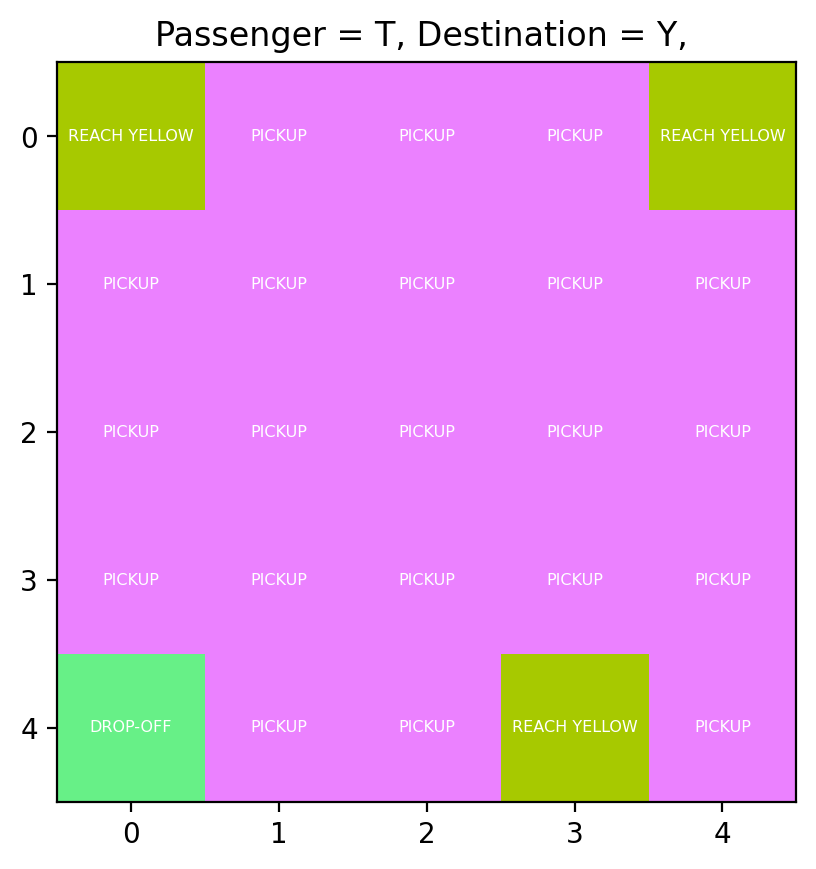

In [68]:
plot_Qmap_outer(Q_SMDP)

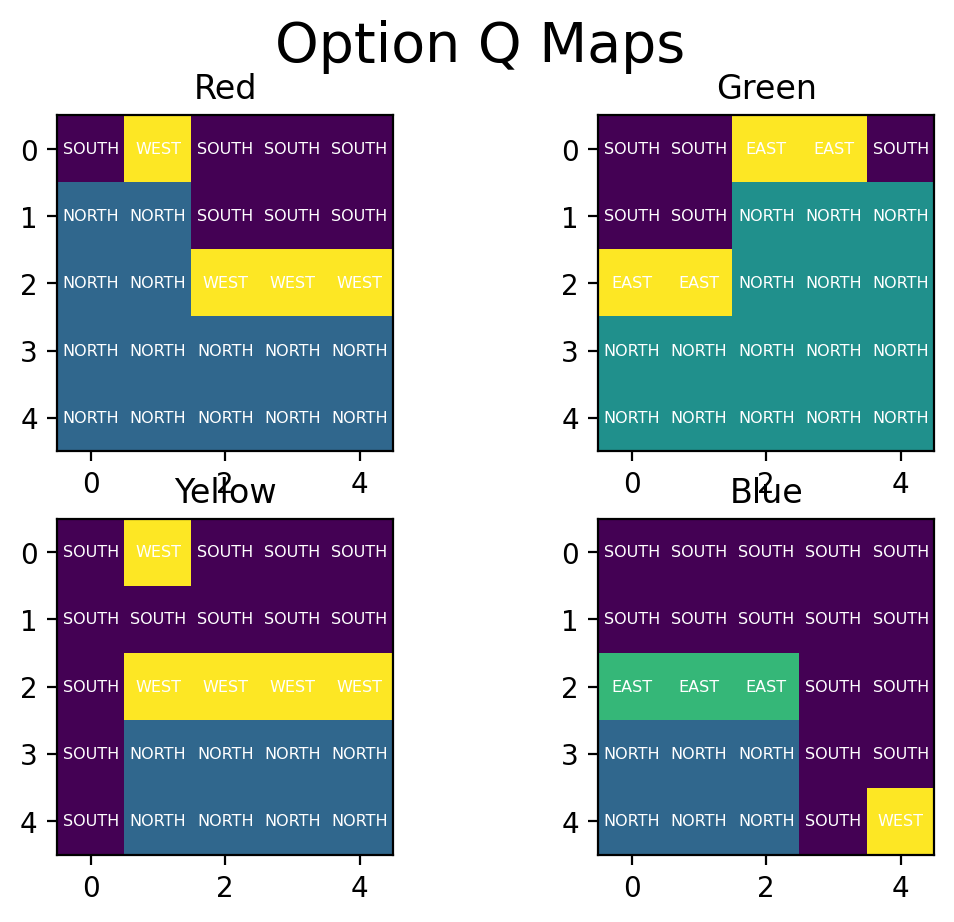

In [38]:
plot_option_Q_maps(*option_Qs)

In [61]:
runs = 5
num_episodes = 30000

num_states = 500
num_actions = 2
num_options = 4
num_taxiLoc = 25
num_movement_actions = 4

returns_IO = np.zeros((runs, num_episodes))
for i in range(runs):
    print(f"Run {i}:")
    Q = np.zeros((num_states, num_actions+num_options))
    Qred = np.zeros((num_taxiLoc, num_movement_actions))
    Qgreen = np.zeros((num_taxiLoc, num_movement_actions))
    Qyellow = np.zeros((num_taxiLoc, num_movement_actions))
    Qblue = np.zeros((num_taxiLoc, num_movement_actions))
    option_Qs = [Qred, Qgreen, Qyellow, Qblue]
    option_handles = [reachRed, reachGreen, reachYellow, reachBlue]
    Q = np.zeros((num_states, num_actions+num_options))
    option_Qs, Q_IO, episodic_returns_IO = IO_Qlearning(option_Qs, option_handles, total_episodes = num_episodes)
    returns_IO[i] = np.array(episodic_returns_IO)

Run 0:


100%|██████████████████████████████████████████████████| 30000/30000 [00:06<00:00, 4363.36it/s]


Run 1:


100%|██████████████████████████████████████████████████| 30000/30000 [00:06<00:00, 4368.15it/s]


Run 2:


100%|██████████████████████████████████████████████████| 30000/30000 [00:07<00:00, 4279.36it/s]


Run 3:


100%|██████████████████████████████████████████████████| 30000/30000 [00:06<00:00, 4388.73it/s]


Run 4:


100%|██████████████████████████████████████████████████| 30000/30000 [00:06<00:00, 4325.84it/s]


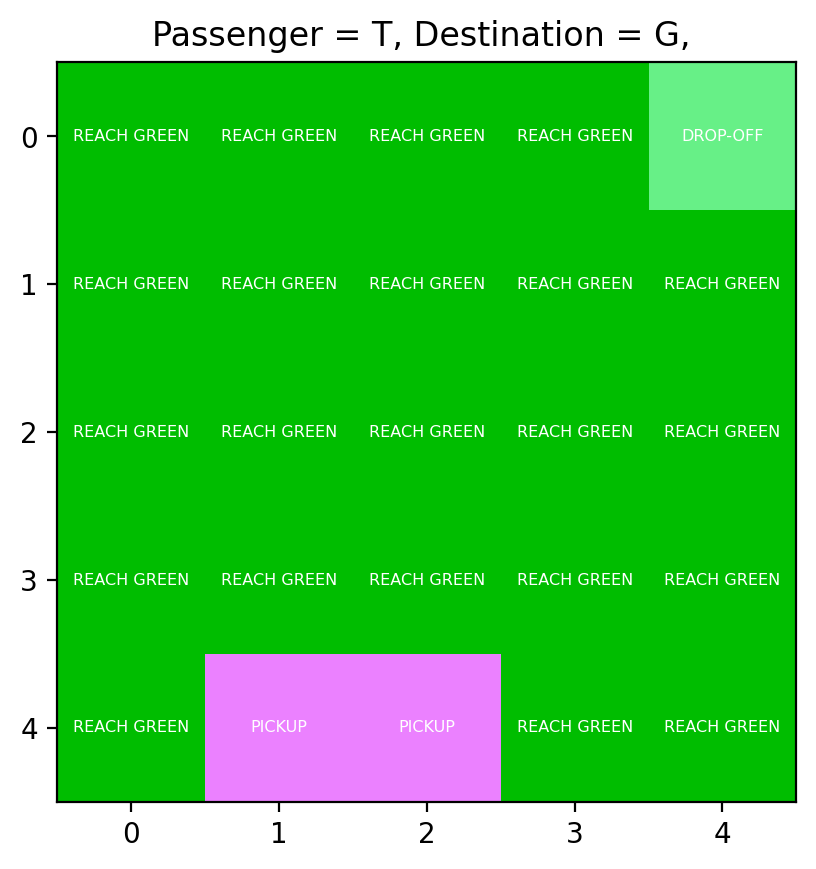

In [76]:
plot_Qmap_outer(Q_IO)

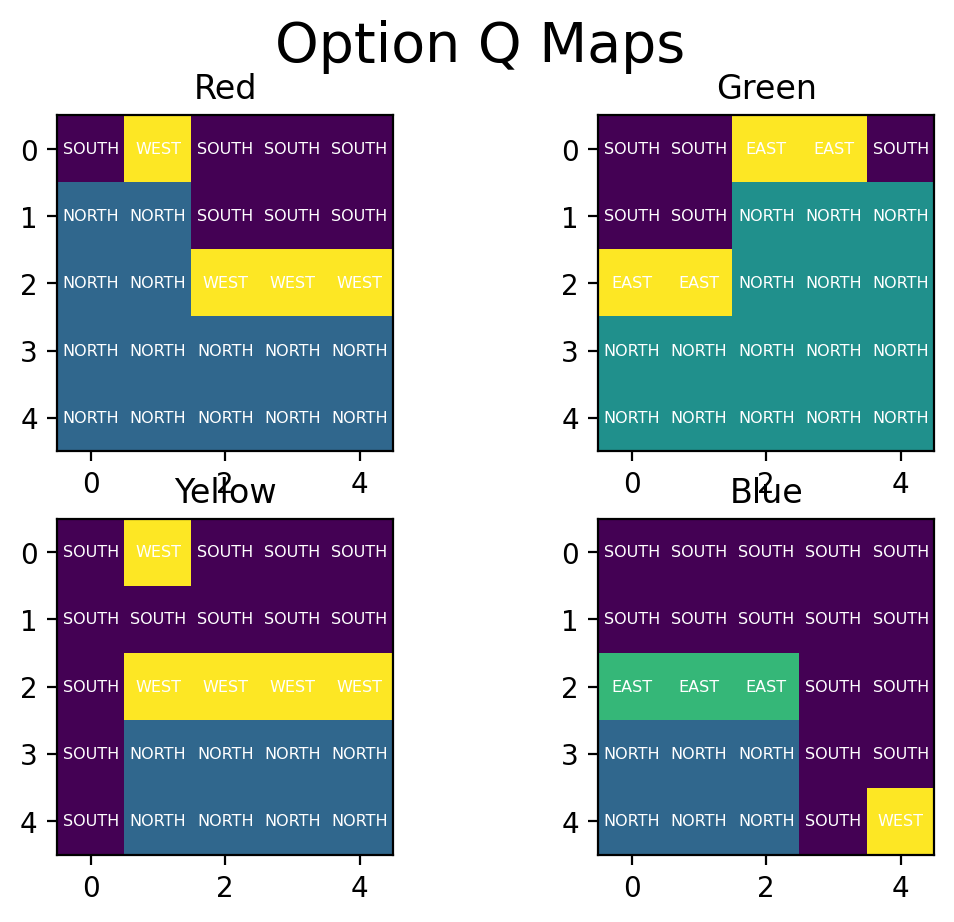

In [63]:
plot_option_Q_maps(*option_Qs)

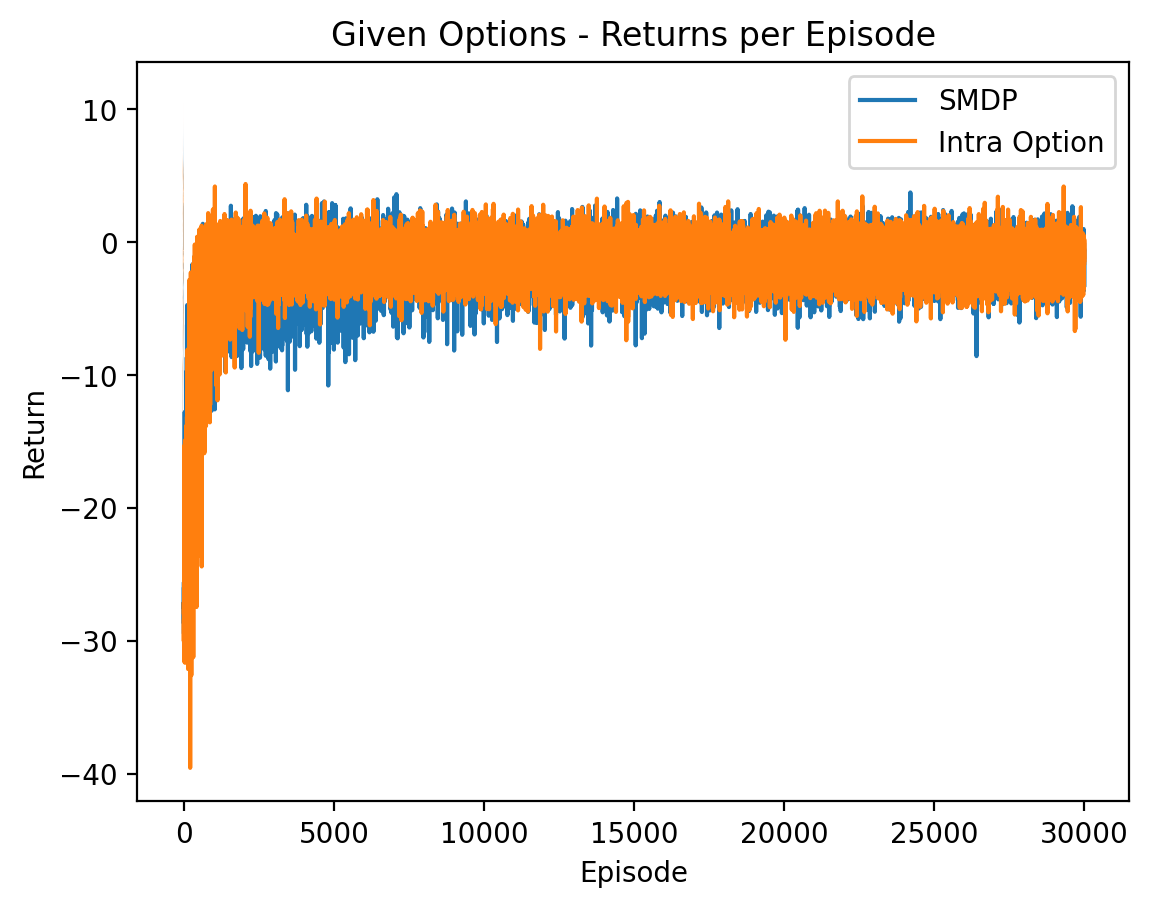

In [67]:
mean_data = np.mean(returns_SMDP, axis=0)
variance_data = np.var(returns_SMDP, axis=0)
shade_data_1ow = mean_data - np.sqrt(variance_data)
shade_data_high = mean_data + np.sqrt(variance_data)

plt.plot(mean_data, label='SMDP')
plt.fill_between(shade_data_1ow, shade_data_high, alpha=0.3)

mean_data = np.mean(returns_IO, axis=0)
variance_data = np.var(returns_IO, axis=0)
shade_data_1ow = mean_data - np.sqrt(variance_data)
shade_data_high = mean_data + np.sqrt(variance_data)

plt.plot(mean_data, label='Intra Option')
plt.fill_between(shade_data_1ow, shade_data_high, alpha=0.3)
# plt.plot(best_return*np.ones(total_episodes,)[:min_length])
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title(f'Given Options - Returns per Episode')
# plt.savefig(env_name+'_'+hyperparameters["dueling_type"]+'.pdf')
plt.show()